In [1]:
#import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
plt.rcParams['agg.path.chunksize'] = 10000
from matplotlib.pyplot import figure
from ete3 import Tree
import os 
import ete3
from scipy.optimize import curve_fit
import scipy 
import numpy.ma as ma
from sklearn.metrics import r2_score
import dendropy
#r2 = r2_score(gt_height, inferred_heights)
def func(x, a):
    return a * x
def func_i(x, a, b):
    return a * x + b
def func_i(x, a):
    return a * x - np.log(0.01)*a
path = 'simulated/v8_ginkgo'
with open(path + '/gt.nw', 'r') as tree_file:
        gt_tree = tree_file.read().replace('\n', ';')
        #print(gt_tree)
        gt_tree = Tree(gt_tree, format = 3)
def read_trees(file):
    tree_collection = []
    for newick in open(file):
        tree_collection.append(Tree(newick))
    return tree_collection

def root_by_diploid(trees):
    tree_collection = []
    for tree in trees:
        tree.set_outgroup( "diploid" )
        for node in tree.traverse():
            if node.name == 'diploid':
                node.detach()
        tree_collection.append(tree)
    return tree_collection

def get_partition(tree, minimal_value):
    partition = []
    partition_edge = []
    for node in tree.traverse():
        L = []
        if node.is_root():
            pass
        elif node.up.is_root():
            pass
        elif node.is_leaf():
            pass
        else:
             if node.dist > minimal_value:
                #print(node.name)
                for leaf in node:
                    L.append(leaf.name)
                partition.append(sorted(L))
                partition_edge.append(node.dist)
    #print(partition_edge)
    return partition, partition_edge

def get_tp_rate(gt_tree, min_branch, tree_list):
    gt_partition, corres_edge = get_partition(gt_tree, 0)
    clade_count = [0]* len(gt_partition)
    for tree in tree_list: 
        partition = get_partition(tree, 0)[0]
        for i in range(0, len(gt_partition)):
            if all(elem in partition for elem in [gt_partition[i]]):
                #print('in')
                clade_count[i] = clade_count[i] + 1
    #print([n/len(tree_list) for n in clade_count])
    return clade_count, corres_edge, len(tree_list)

def isfloat(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

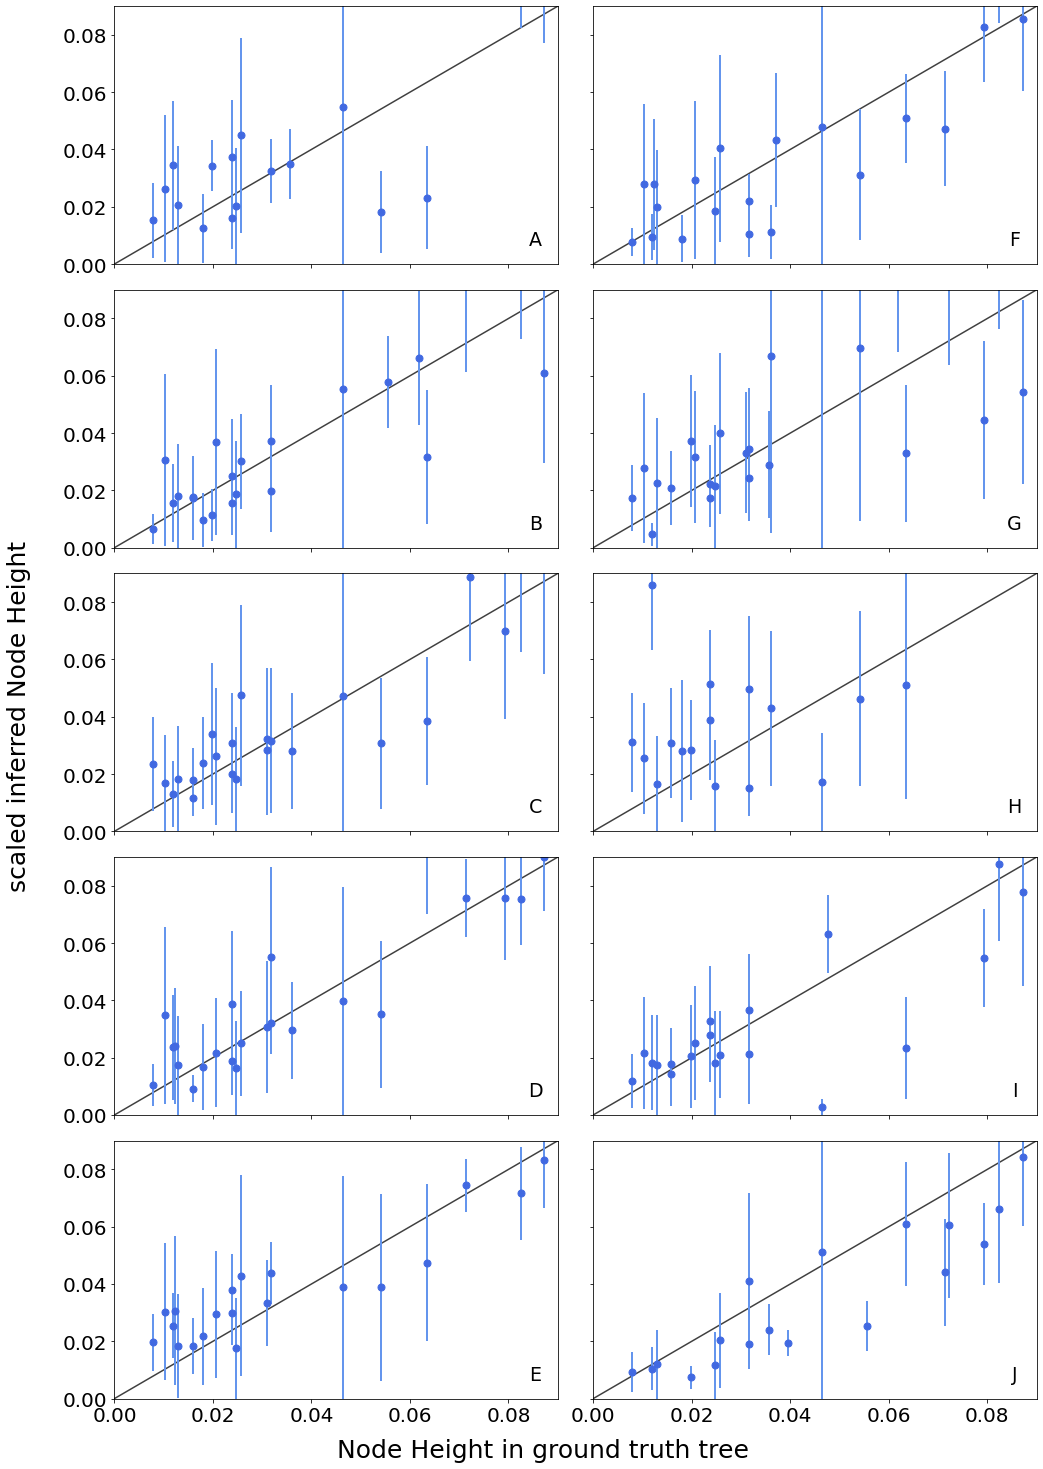

In [2]:
plt.rcParams["figure.figsize"] = [14, 20]
fig, ax = plt.subplots(5, 2)
a = 0
b = 0
lx = np.linspace(0, 0.1,1)
char_ = 'A'
gt_height_gk = []
inferred_height_gk = []
for rep in ['rep0', 'rep1','rep2','rep3','rep4','rep5','rep6','rep7','rep8','rep9']:
    print(rep)
    height = {}
    median = {}
    tree = dendropy.Tree.get(path="simulated/v8_ginkgo/real_" + rep + "/summary.tree", schema="nexus", extract_comment_metadata=True)
    tree.calc_node_ages()
    for node in tree.postorder_node_iter():
        gt_h = node.age
        hpd = node.annotations.values_as_dict(key_func=lambda a: a.namespace + a.name, value_attr="value")['age_hpd95']
        med = node.annotations.values_as_dict(key_func=lambda a: a.namespace + a.name, value_attr="value")['age_median']
        if node.age != 0 and isfloat(hpd[0]):
            median[node.age] = float(med)
            height[node.age] = [float(num) for num in hpd]
    lists = sorted(median.items()) # sorted by key, return a list of tuples
    x, y = zip(*lists) # unpack a list of pairs into two tuples
    m = curve_fit(func,x, y)
# now plot both limits against eachother
    ax[a,b].plot([0,1], [0,1], 'k-', alpha=0.75, zorder=0)
    ax[a,b].xaxis.grid(True, which='major')
    ax[a,b].yaxis.grid(True, which='major')
    ax[a,b].set_xlim([0,0.09])
    ax[a,b].set_ylim([0,0.09])
    if b == 1:
        ax[a,b].axes.yaxis.set_ticklabels([])
    if a != 4: 
        ax[a,b].axes.xaxis.set_ticklabels([])
    ax[a,b].tick_params(axis='both', which='major', labelsize=20, grid_alpha = 0, reset= True, direction = 'out', top = False, right = False)
    ax[a,b].set_title(char_, fontsize = 19, x = 0.95, y = 0.05)
    for i in height:
        ax[a,b].vlines(i, height[i][0]/m[0][0], height[i][1]/m[0][0], color='cornflowerblue', linewidth = 2)
        ax[a,b].plot(i, (height[i][0]/m[0][0] + height[i][1]/m[0][0])/2, 'bo', color='royalblue',markersize=7)
        gt_height_gk.append(i)
        inferred_height_gk.append((height[i][0]/m[0][0] + height[i][1]/m[0][0])/2)
    char_ = chr(ord(char_)+1)
    if a < 4:
        a = a + 1
    else:
        a = 0
        b = b + 1  
plt.tight_layout(h_pad=0.2, w_pad=0.1)
fig.text(0.5, -0.01, 'Node Height in ground truth tree', ha='center', va='center', fontsize = 25)
fig.text(-0.02, 0.5, 'scaled inferred Node Height', ha='center', va='center', rotation='vertical', fontsize = 25)
plt.subplots_adjust(hspace = 0.1)
plt.subplots_adjust(wspace = 0.08)
plt.show() 

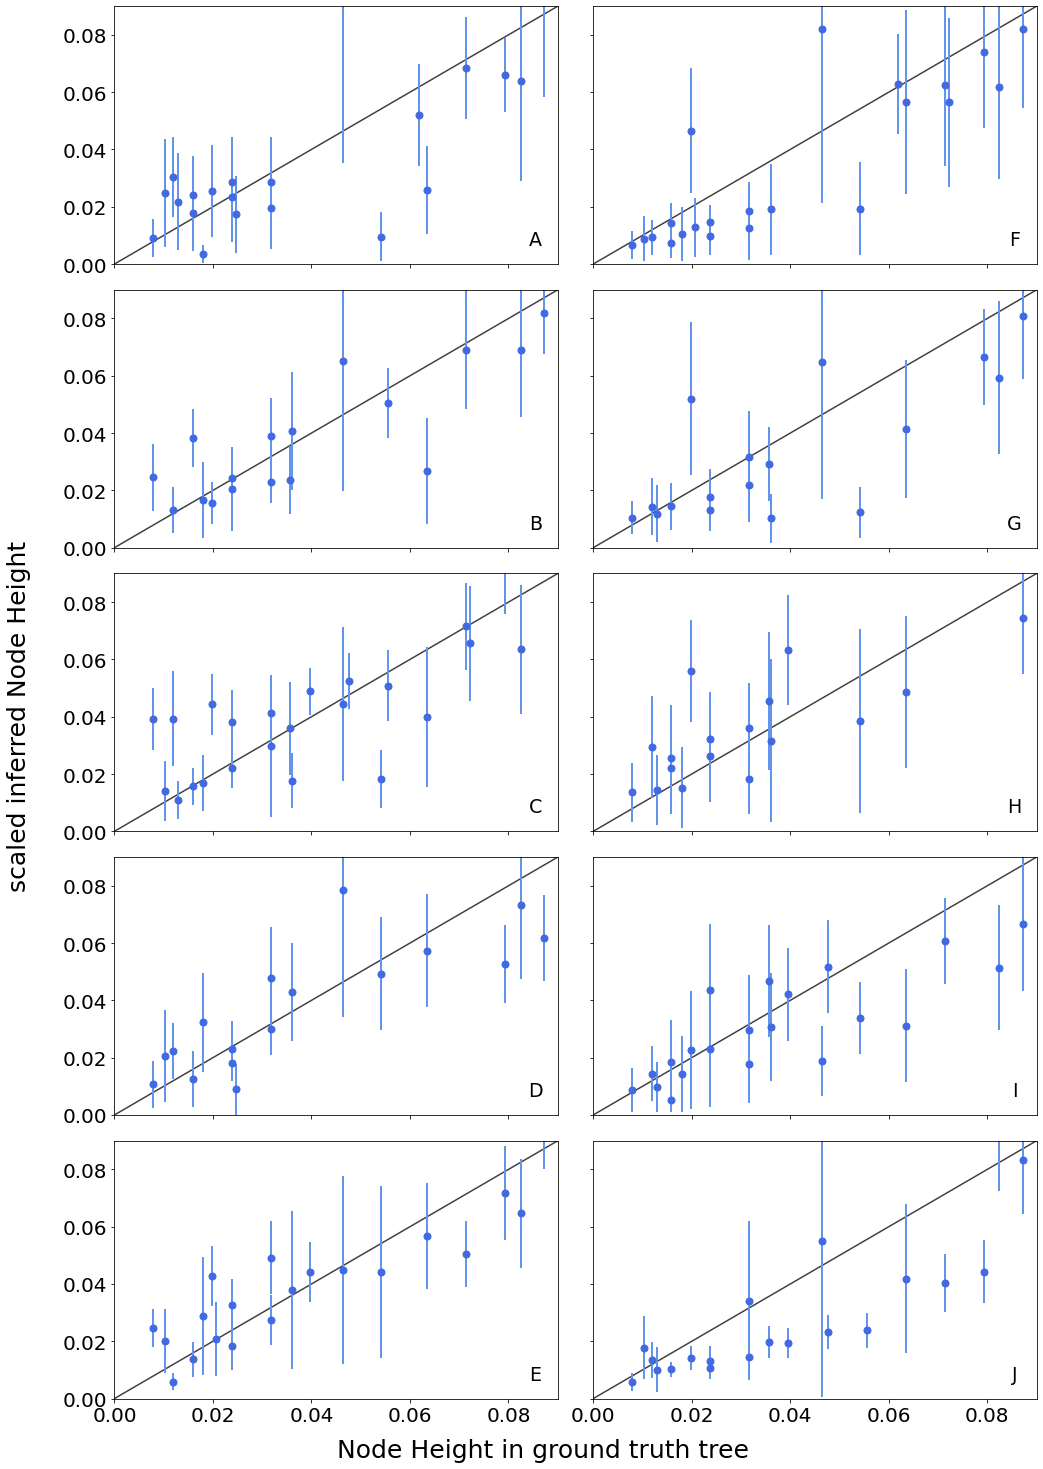

In [3]:
plt.rcParams["figure.figsize"] = [14, 20]
fig, ax = plt.subplots(5, 2)
a = 0
b = 0
lx = np.linspace(0, 0.1,1)
char_ = 'A'
gt_height_gt = []
inferred_height_gt = []
for rep in ['rep0', 'rep1','rep2','rep3','rep4','rep5','rep6','rep7','rep8','rep9']:
    print(rep)
    height = {}
    median = {}
    tree = dendropy.Tree.get(path="simulated/v8_gt/real_" + rep + "/summary.tree", schema="nexus", extract_comment_metadata=True)
    tree.calc_node_ages()
    for node in tree.postorder_node_iter():
        gt_h = node.age
        hpd = node.annotations.values_as_dict(key_func=lambda a: a.namespace + a.name, value_attr="value")['age_hpd95']
        med = node.annotations.values_as_dict(key_func=lambda a: a.namespace + a.name, value_attr="value")['age_median']
        if node.age != 0 and isfloat(hpd[0]):
            median[node.age] = float(med)
            height[node.age] = [float(num) for num in hpd]
    lists = sorted(median.items()) # sorted by key, return a list of tuples
    x, y = zip(*lists) # unpack a list of pairs into two tuples
    m = curve_fit(func,x, y)
    ax[a,b].plot([0,1], [0,1], 'k-', alpha=0.75, zorder=0)
    #print(gt_height)
    #plt.title('distribution of inferred node height taken from MCMC samples after scaling -'+ rep)
    ax[a,b].xaxis.grid(True, which='major')
    ax[a,b].yaxis.grid(True, which='major')
    ax[a,b].set_xlim([0,0.09])
    ax[a,b].set_ylim([0,0.09])
    if b == 1:
        ax[a,b].axes.yaxis.set_ticklabels([])
    if a != 4: 
        ax[a,b].axes.xaxis.set_ticklabels([])
    ax[a,b].tick_params(axis='both', which='major', labelsize=20, grid_alpha = 0, reset= True, direction = 'out', top = False, right = False)
    ax[a,b].set_title(char_, fontsize = 19, x = 0.95, y = 0.05)
    for i in height:
        #print(median[i])
        ax[a,b].vlines(i, height[i][0]/m[0][0], height[i][1]/m[0][0], color='cornflowerblue', linewidth = 2)
        ax[a,b].plot(i, (height[i][0]/m[0][0] + height[i][1]/m[0][0])/2, 'bo', color='royalblue',markersize=7)
        gt_height_gt.append(i)
        inferred_height_gt.append((height[i][0]/m[0][0] + height[i][1]/m[0][0])/2)
    char_ = chr(ord(char_)+1)
    if a < 4:
        a = a + 1
    else:
        a = 0
        b = b + 1  
plt.tight_layout(h_pad=0.2, w_pad=0.1)
fig.text(0.5, -0.01, 'Node Height in ground truth tree', ha='center', va='center', fontsize = 25)
fig.text(-0.02, 0.5, 'scaled inferred Node Height', ha='center', va='center', rotation='vertical', fontsize = 25)
plt.subplots_adjust(hspace = 0.1)
plt.subplots_adjust(wspace = 0.08)
plt.show() 

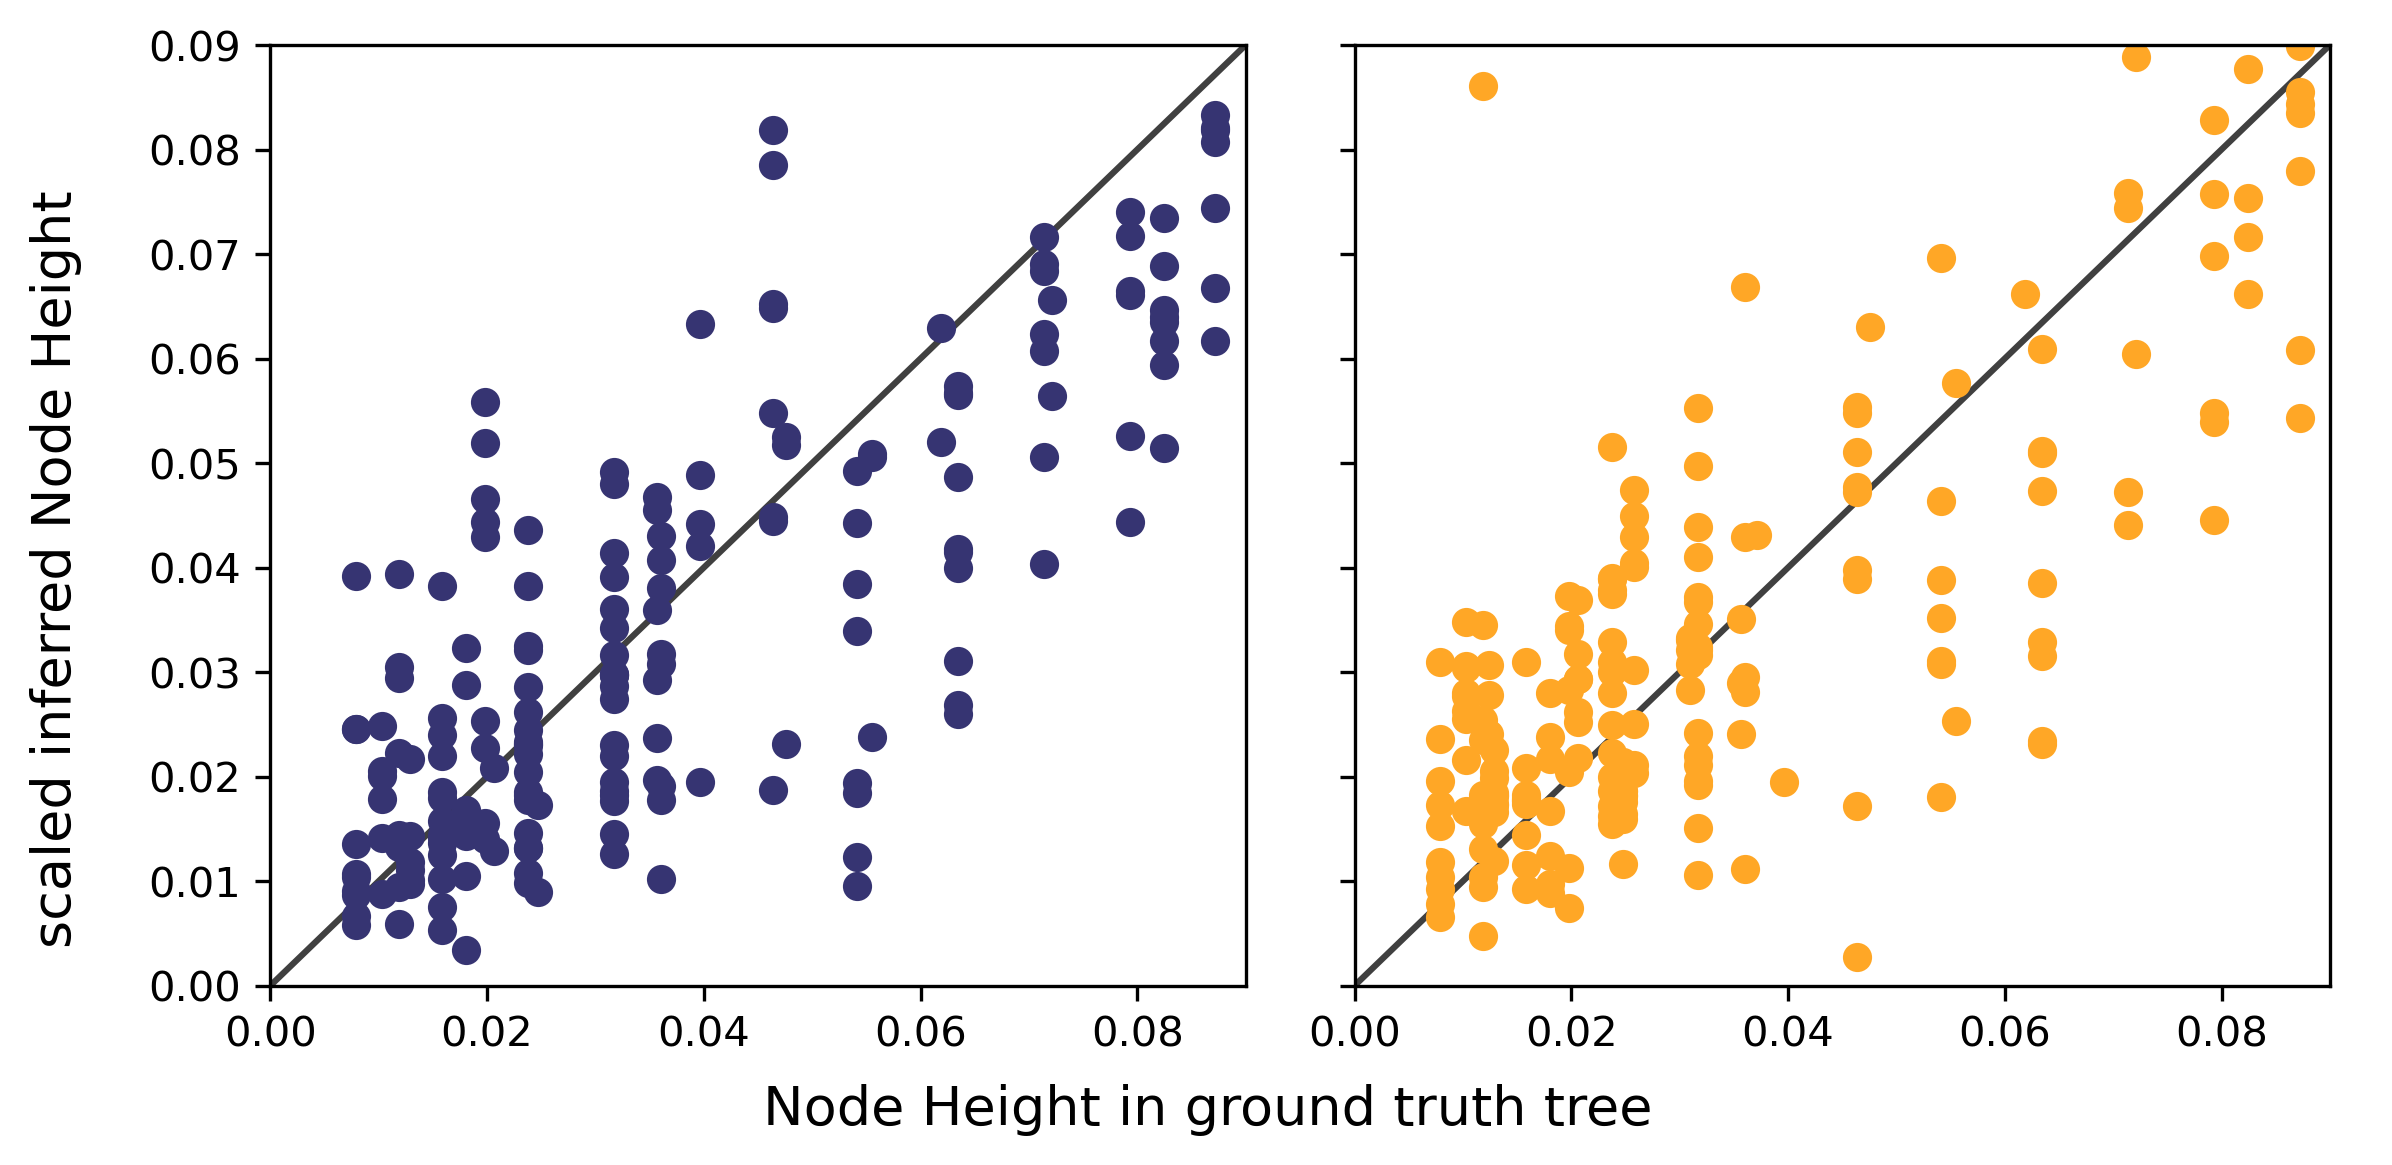

In [4]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True,sharey = True, figsize=(8,4), dpi = 300)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
#fig1
ax2.scatter(gt_height_gk, inferred_height_gk, color = '#FFA726')
ax2.plot([0,1], [0,1], 'k-', alpha=0.75, zorder=0)
ax2.set_xlim([0,0.09])
ax2.set_ylim([0,0.09])
#fig2
ax1.scatter(gt_height_gt, inferred_height_gt, color = '#363472')
ax1.plot([0,1], [0,1], 'k-', alpha=0.75, zorder=0)
ax1.set_xlim([0,0.09])
ax1.set_ylim([0,0.09])
fig.text(0.5, 0.05, 'Node Height in ground truth tree', ha='center', va='center', fontsize = 13)
fig.text(0.02, 0.5, 'scaled inferred Node Height', ha='center', va='center', rotation='vertical', fontsize = 13)
fig.tight_layout(w_pad = 1.5)
plt.show()

In [5]:
from collections import defaultdict
import bisect
quantiles = []
height = []
for num in gt_height_gk:
    height.append(num)
for num in np.linspace(0,1,11):
    quantiles.append(np.quantile(height, num))
def qs(quantile, node):
    qs = bisect.bisect_left(quantiles, node)
    if qs == 0:
        pass
    else: 
        qs = qs -1
    return qs

In [6]:
d_gt = defaultdict(list)
for rep in ['rep0', 'rep1','rep2','rep3','rep4','rep5','rep6','rep7','rep8','rep9']:
    height = {}
    median = {}
    tree = dendropy.Tree.get(path="simulated/v8_gt/real_" + rep + "/summary.tree", schema="nexus", extract_comment_metadata=True)
    tree.calc_node_ages()
    for node in tree.postorder_node_iter():
        gt_h = node.age
        hpd = node.annotations.values_as_dict(key_func=lambda a: a.namespace + a.name, value_attr="value")['age_hpd95']
        med = node.annotations.values_as_dict(key_func=lambda a: a.namespace + a.name, value_attr="value")['age_median']
        if node.age != 0 and isfloat(hpd[0]):
            median[node.age] = float(med)
            height[node.age] = [float(num) for num in hpd]
    lists = sorted(median.items()) # sorted by key, return a list of tuples
    x, y = zip(*lists) # unpack a list of pairs into two tuples
    m = curve_fit(func,x, y)
    for i in height:
        gt_height_gt.append(i)
        n = qs(quantiles,i)
        if i >=height[i][0]/m[0][0] and i <= height[i][1]/m[0][0]:
            d_gt[n].append(1)
        else:
            d_gt[n].append(0)
for key in d_gk.keys():
    d_gt[key] = sum(d_gt[key])/(len(d_gt[key])) 

In [7]:
d_gk = defaultdict(list)
for rep in ['rep0', 'rep1','rep2','rep3','rep4','rep5','rep6','rep7','rep8','rep9']:
    height = {}
    median = {}
    tree = dendropy.Tree.get(path="simulated/v8_ginkgo/real_" + rep + "/summary.tree", schema="nexus", extract_comment_metadata=True)
    tree.calc_node_ages()
    for node in tree.postorder_node_iter():
        gt_h = node.age
        hpd = node.annotations.values_as_dict(key_func=lambda a: a.namespace + a.name, value_attr="value")['age_hpd95']
        med = node.annotations.values_as_dict(key_func=lambda a: a.namespace + a.name, value_attr="value")['age_median']
        if node.age != 0 and isfloat(hpd[0]):
            median[node.age] = float(med)
            height[node.age] = [float(num) for num in hpd]
    lists = sorted(median.items()) # sorted by key, return a list of tuples
    x, y = zip(*lists) # unpack a list of pairs into two tuples
    m = curve_fit(func,x, y)
    for i in height:
        gt_height_gt.append(i)
        n = qs(quantiles,i)
        if i >=height[i][0]/m[0][0] and i <= height[i][1]/m[0][0]:
            d_gk[n].append(1)
        else:
            d_gk[n].append(0)
for key in d_gk.keys():
    d_gk[key] = sum(d_gk[key])/(len(d_gk[key]))

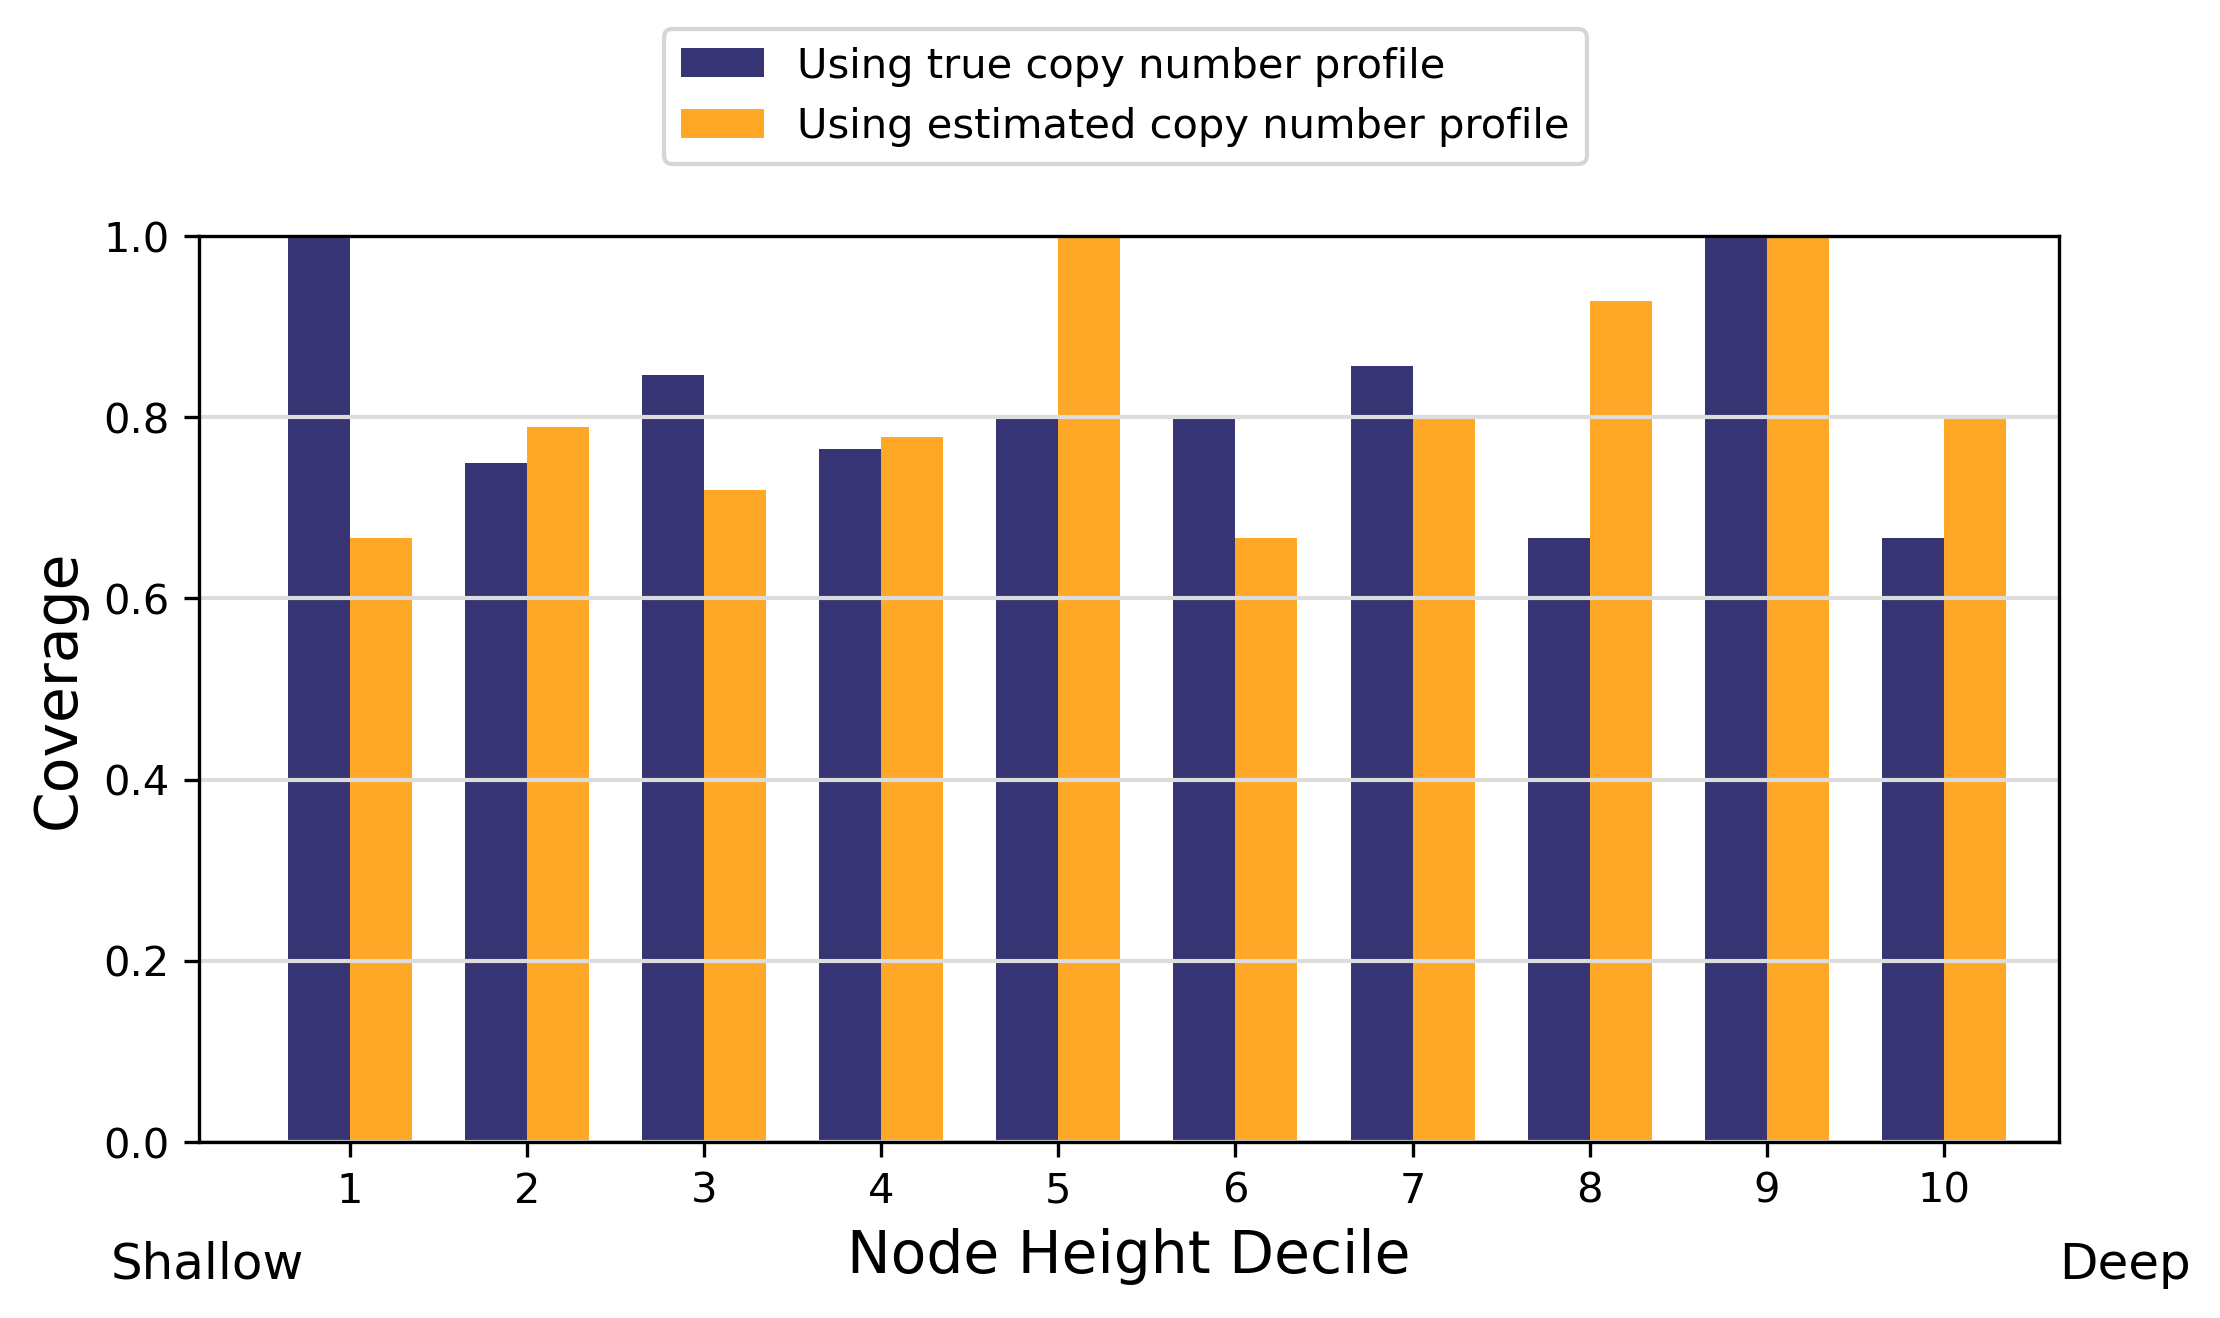

In [8]:
figure(figsize=(8,4), dpi=300)
ax = plt.subplot(111)
dec = np.arange(1,11)
plt.bar(dec,d_gk.values(),0.35, label='Using true copy number profile', color = '#363472',align='edge')
plt.bar(dec+0.35,d_gt.values(), 0.35, label='Using estimated copy number profile', color = '#FFA726', align = 'edge')
plt.ylabel('Coverage', fontsize = 14)
plt.xlabel('Node Height Decile', fontsize = 14)
plt.grid(color = 'gainsboro', linewidth = 1,axis='y')
ax.text(0 ,-0.15, 'Shallow', fontsize = 12)
ax.text(11,-0.15, 'Deep', fontsize = 12)
plt.ylim(0, 1)
plt.xlim(0.5,11)
plt.xticks(dec+0.35, np.array([1,2,3,4,5,6,7,8,9,10]))
plt.legend(loc=[0.25,1.08])
plt.show()